Get monitor data, total V scattering, and number of pulses

In [1]:
cd /SNS/users/lj7/dv/sns-chops/resolution/ARCS/

/SNS/users/lj7/dv/sns-chops/resolution/ARCS


In [2]:
#Program to load Vanadium or empty Can powder files and perform a constant-Q cut along the middle Q to look at energy resolution and intensity.
import matplotlib.pyplot as plt
from mantid import plots
from mantid.simpleapi import Load, ConvertToMD, BinMD, ConvertUnits, Rebin
from matplotlib.colors import LogNorm
import numpy as np
import mantid.simpleapi as msa
from mantid import mtd

In [3]:
from mcni.utils import conversion as C

In [4]:
%matplotlib notebook

In [5]:
# ls /SNS/ARCS/IPTS-21387/nexus/

In [6]:
RunNumbers=range(107970,108193)
print(RunNumbers)
IPTS=21387
datadir="/SNS/ARCS/IPTS-"+str(IPTS)+"/shared/autoreduce/"

[107970, 107971, 107972, 107973, 107974, 107975, 107976, 107977, 107978, 107979, 107980, 107981, 107982, 107983, 107984, 107985, 107986, 107987, 107988, 107989, 107990, 107991, 107992, 107993, 107994, 107995, 107996, 107997, 107998, 107999, 108000, 108001, 108002, 108003, 108004, 108005, 108006, 108007, 108008, 108009, 108010, 108011, 108012, 108013, 108014, 108015, 108016, 108017, 108018, 108019, 108020, 108021, 108022, 108023, 108024, 108025, 108026, 108027, 108028, 108029, 108030, 108031, 108032, 108033, 108034, 108035, 108036, 108037, 108038, 108039, 108040, 108041, 108042, 108043, 108044, 108045, 108046, 108047, 108048, 108049, 108050, 108051, 108052, 108053, 108054, 108055, 108056, 108057, 108058, 108059, 108060, 108061, 108062, 108063, 108064, 108065, 108066, 108067, 108068, 108069, 108070, 108071, 108072, 108073, 108074, 108075, 108076, 108077, 108078, 108079, 108080, 108081, 108082, 108083, 108084, 108085, 108086, 108087, 108088, 108089, 108090, 108091, 108092, 108093, 108094,

# debug

In [7]:
RunNumber = RunNumbers[0]
path = '/SNS/ARCS/IPTS-%s/nexus/ARCS_%s.nxs.h5' % (IPTS, RunNumber)
w = msa.LoadEventNexus(path)
mons = msa.LoadNexusMonitors(path)

In [8]:
mons.getNumberHistograms()

2

In [9]:
RunParams=w.getRun()
Energy=RunParams["BL18:Chop:Skf0:EnergyUserReq"].getStatistics().mean

In [10]:
v = C.e2v(Energy)

In [11]:
LM1 = 11.831
t = LM1/v*1e6
print t

9563.22383736


In [12]:
mon1 = mons.getSpectrum(0)
tofs = mon1.getTofs()
weights = mon1.getWeights()
intensities, tofbbs = np.histogram(tofs, weights=weights, bins=100, range=(t*.8, t*1.2))
tofcenters = (tofbbs[1:]+tofbbs[:-1])/2

<IPython.core.display.Javascript object>


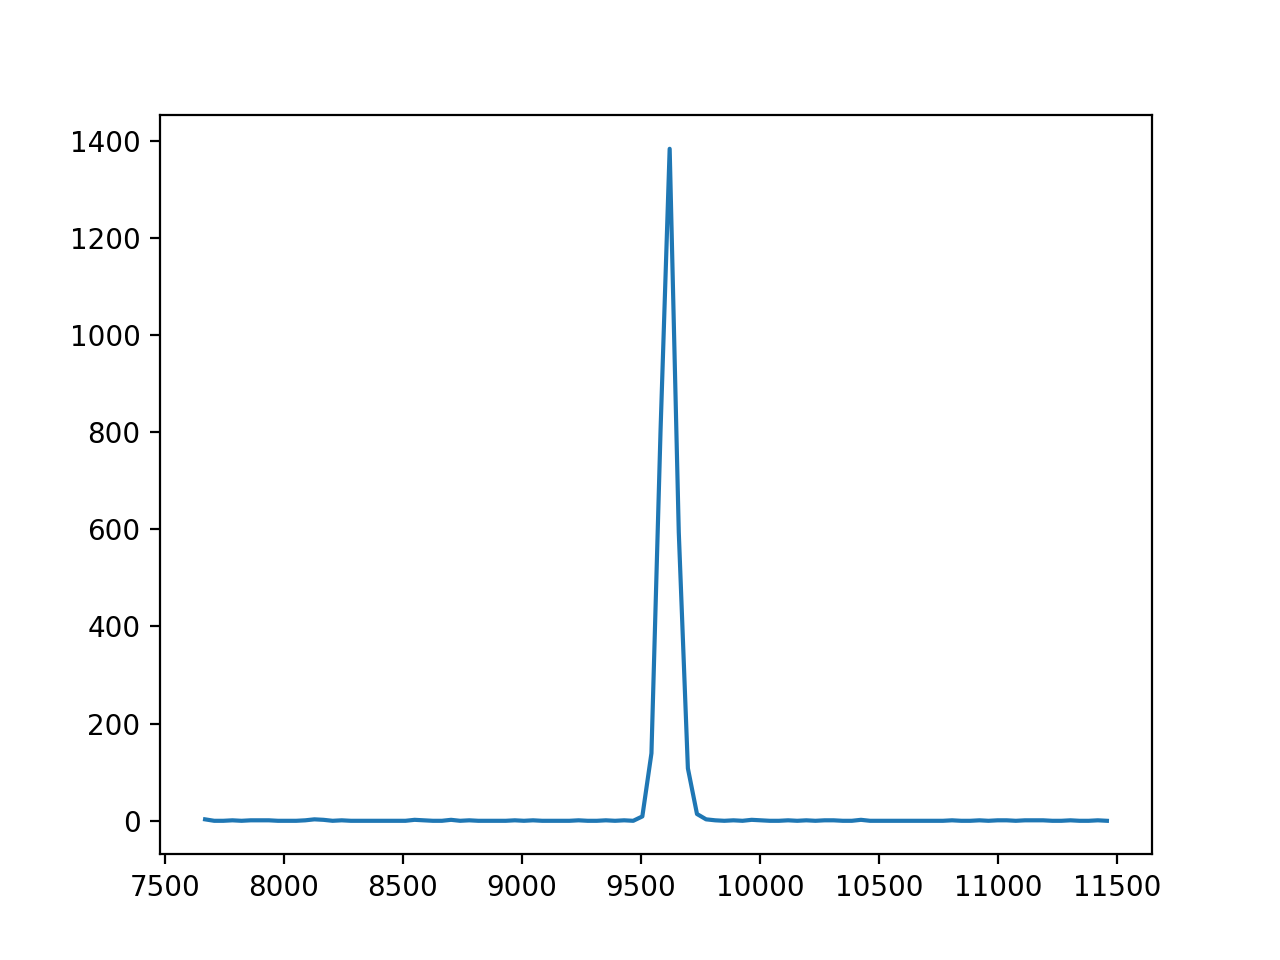

In [13]:
plt.figure()
plt.plot(tofcenters, intensities)

## Total scattering

In [15]:
print w.getNumberEvents()

625987


## Time

In [21]:
print RunParams['duration'].value
print RunParams['start_time'].value
print RunParams['end_time'].value

8461.05273438
2018-06-09T21:28:54.010994666
2018-06-09T23:49:55.063966666


# gather data
**This can be skipped the 2nd time running this notebook**

In [7]:
LM1 = 11.831

17min

In [9]:
%%time
PlotTag=0

data_table = {}

import tqdm
for RunNumber in tqdm.tqdm(RunNumbers):
    # print (RunNumber)
    path = '/SNS/ARCS/IPTS-%s/nexus/ARCS_%s.nxs.h5' % (IPTS, RunNumber)
    w = msa.LoadEventNexus(path)
    mons = msa.LoadNexusMonitors(path)
    RunParams=w.getRun()
    Energy=RunParams["BL18:Chop:Skf0:EnergyUserReq"].getStatistics().mean
    v = C.e2v(Energy)
    t = LM1/v*1e6
    mon1 = mons.getSpectrum(0)
    tofs = mon1.getTofs()
    weights = mon1.getWeights()
    intensities, tofbbs = np.histogram(tofs, weights=weights, bins=100, range=(t*.8, t*1.2))
    tofcenters = (tofbbs[1:]+tofbbs[:-1])/2
    totscatt = w.getNumberEvents()
    duration = RunParams['duration'].value
    data_table[RunNumber] = (tofcenters, intensities), totscatt, duration
    # break
    continue

100%|██████████| 223/223 [17:54<00:00,  4.46s/it]

CPU times: user 14min 35s, sys: 35.6 s, total: 15min 10s
Wall time: 17min 55s


## Save

In [10]:
import pickle as pkl

In [11]:
pkl.dump(data_table, open('V_Cali_MonitorInt_FC2_2018_v2_datatable.pkl', 'w'))

# Load data from saved file

In [12]:
data_table = pkl.load(open('./V_Cali_MonitorInt_FC2_2018_v2_datatable.pkl'))

examine data

<IPython.core.display.Javascript object>


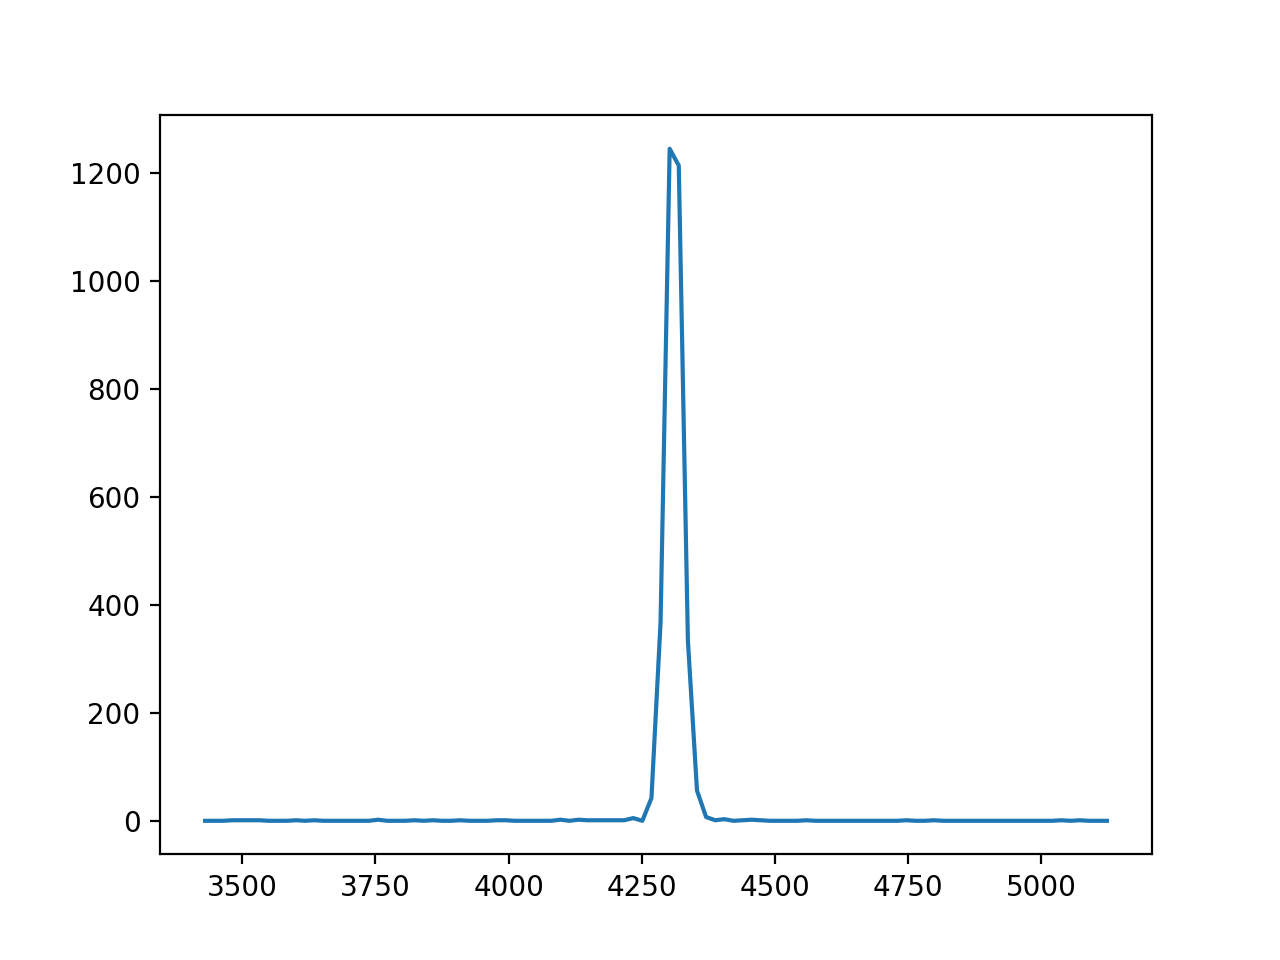

In [13]:
(tof,I), totscatt, duration =  data_table[RunNumbers[50]]
plt.figure()
plt.plot(tof, I)

In [14]:
print totscatt, duration

925925 311.2137146


In [15]:
intensity_data = [(k, I.sum(), totscatt, duration) for k, ((tof, I), totscatt, duration) in data_table.items()]

In [16]:
intensity_data = np.array(intensity_data)

In [17]:
np.savetxt('V_Cali_MonitorInt_FC2_2018_v2.dat', intensity_data)

In [18]:
more ./V_Cali_MonitorInt_FC2_2018_v2.dat

# Inspect 

In [9]:
import sys, os
sys.path.insert(0, os.path.abspath('./PyChop/'))

In [10]:
import Vdata2018
reload(Vdata2018)

<module 'Vdata2018' from '/SNS/users/lj7/dv/sns-chops/resolution/ARCS/PyChop/Vdata2018.pyc'>

In [11]:
expdata = Vdata2018.ExpData(os.path.join(Vdata2018.datadir, './V_Cali_Int_Res_FC2_2018_v2.dat'))

reading data. please wait...
  done


<IPython.core.display.Javascript object>


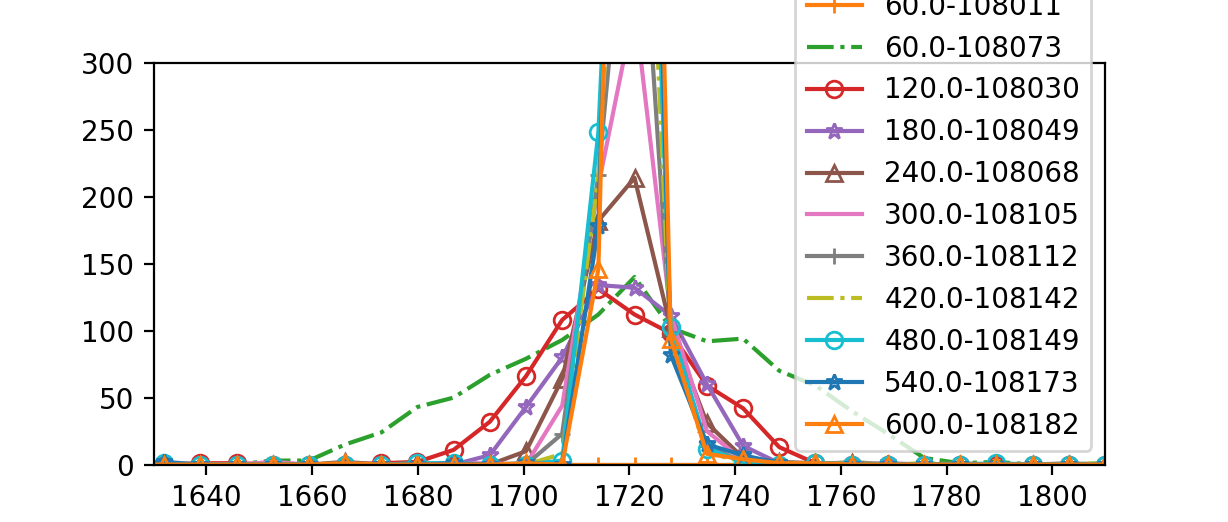

<IPython.core.display.Javascript object>


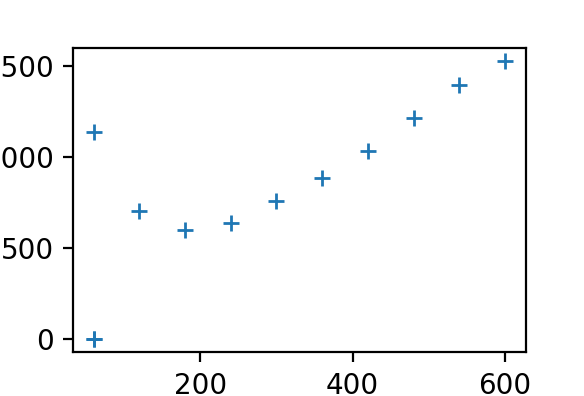

In [41]:
Ei = 250.
condition = np.isclose(expdata.vdata.Energy, Ei)

# expdata.chopper_freqs[condition]
# expdata.vdata.RunNumber[condition]

plt.figure()
# for run in [108073, 108011, 107987]:
runs, freqs = expdata.vdata.RunNumber[condition], expdata.chopper_freqs[condition]
totint = []; freqs2 = []
import itertools
marker = itertools.cycle((',', '+', '.', 'o', '*', '^')) 
for freq, run in sorted(zip(freqs, runs)):
    tof,I =  data_table[run]
    plt.plot(tof, I, '-'+marker.next(), mfc='none', label='%s-%s'%(freq, int(run)))
    # print I.sum()
    totint.append(I.sum())
    freqs2.append(freq)
plt.legend()
plt.xlim(1630, 1810)
plt.ylim(0, 300)

plt.figure()
plt.plot(freqs2, totint, '+')

<IPython.core.display.Javascript object>


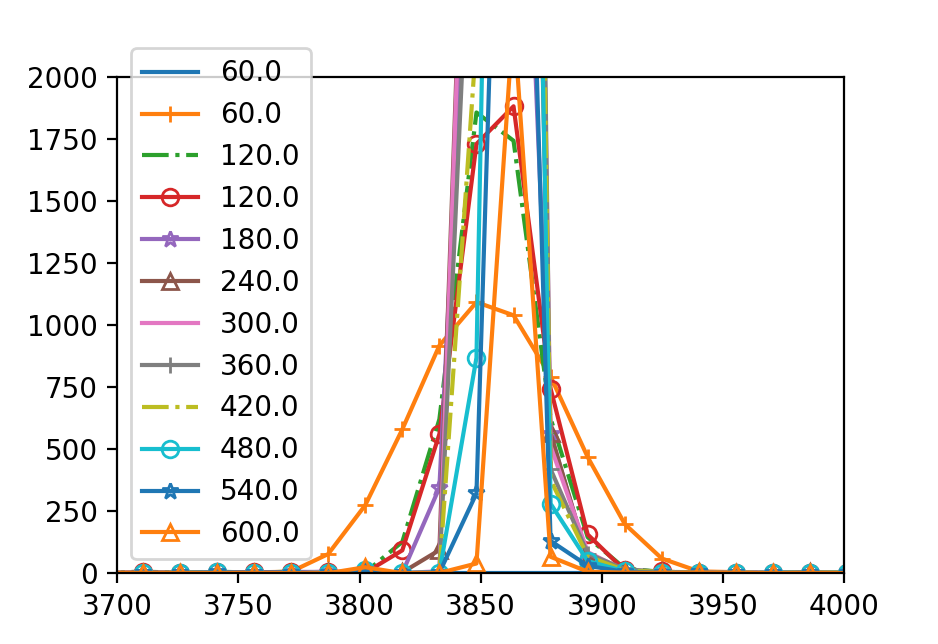

<IPython.core.display.Javascript object>


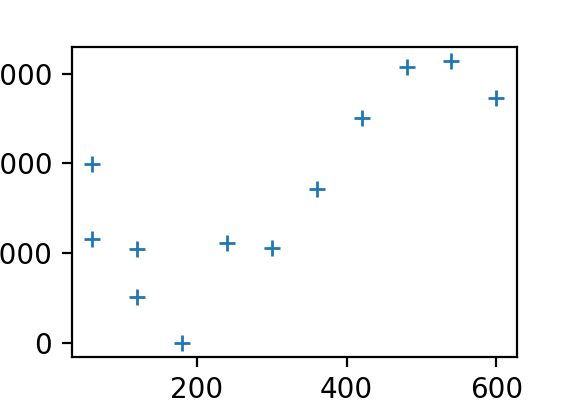

In [40]:
Ei = 50.
condition = np.isclose(expdata.vdata.Energy, Ei)

# expdata.chopper_freqs[condition]
# expdata.vdata.RunNumber[condition]

plt.figure()
# for run in [108073, 108011, 107987]:
runs, freqs = expdata.vdata.RunNumber[condition], expdata.chopper_freqs[condition]

import itertools
marker = itertools.cycle((',', '+', '.', 'o', '*', '^')) 
totint = []
for freq, run in sorted(zip(freqs, runs)):
    tof,I =  data_table[run]
    plt.plot(tof, I, '-'+marker.next(), mfc='none', label=freq)
    # print I.sum()
    totint.append(I.sum())

plt.legend()
plt.xlim(3700, 4000)
plt.ylim(0, 2000)

plt.figure()
plt.plot(freqs, totint, '+')